# CommaAI Speed Challenge

In this notebook, we explore a solution to the speed prediction challenge by Comma AI.

## Imports

In [17]:
import copy
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from matplotlib import pyplot as plt
from time import time
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

## Helper Methods

In [2]:
def video_frame_generator(filename):
    """
    A generator function that returns a frame on each 'next()' call.

    :param str filename: The video filename.
    :return: A frame.
    """
    video = cv2.VideoCapture(filename)

    while video.isOpened():
        ret, frame = video.read()

        if ret:
            yield frame
        else:
            break

    video.release()

def get_frames(filename, limit=None):
    """
    Gets all the frames from the given video file as grayscale images.

    :param str filename: The video filename.
    :param int limit: The maximum number of frames to return. Defaults to `None`, i.e. all frames.
    :return: A list of frames.
    :rtype: list[numpy.ndarray]
    """
    frames = []

    for i, frame in enumerate(video_frame_generator(filename)):
        if limit is not None and i > limit:
            return frames

        frames.append(cv2.cvtColor(np.copy(frame), cv2.COLOR_BGR2GRAY))

    return frames

def normalize_and_scale(image, scale_range=(0, 255)):
    """
    Normalizes and scales an image to a given range.

    :param numpy.ndarray image: The image to normalize and scale.
    :param tuple scale_range: The range [min, max] for normalizing and scaling. Defaults to [0, 255].
    :return: The normalized image.
    :rtype: numpy.ndarray
    """
    image_out = np.zeros(image.shape)
    cv2.normalize(image, image_out, alpha=scale_range[0], beta=scale_range[1], norm_type=cv2.NORM_MINMAX)

    return image_out

## Motion History Images

Hyperparameters that need to be tuned are the **motion threshold** $\theta$ and the **time window threshold** $\tau$.

In [26]:
def motion_segmentation(images, theta=0):
    """
    Generates motion binary images from the given sequence of images.

    :param list[numpy.ndarray] images: The sequence of images that describe some motion.
    :param float theta: The motion threshold. Defaults to 0.
    :return: A list of binary motion images.
    :rtype: list[numpy.ndarray]
    """
    motion_images = [np.zeros_like(images[0], dtype=np.uint8)]

    for i in range(1, len(images)):
        image = images[i]
        prev = images[i - 1]

        motion = (np.abs(image.astype(np.float64) - prev.astype(np.float64)) > theta).astype(np.uint8)
        motion_images.append(motion)

    return motion_images


def motion_history_images(motion_images, tau):
    """
    Generates motion history images from the given sequence of binary motion images.
    Based on "The Representation and Recognition of Action Using Temporal Templates" by Davis and Bobick (1997).

    :param list[numpy.ndarray] motion_images: The sequence of binary motion images. Usually from a call to `motion_segmentation`.
    :param int tau: The time window threshold.
    :return: A list of motion history images.
    :rtype: list[numpy.ndarray]
    """
    mhis = []
    prev_mhi = None

    for motion in motion_images:
        mhi = np.zeros_like(motion, dtype=np.float64)

        # Pixels with motion
        mhi[motion == 1] = tau
        # Decay pixels with no motion
        mhi[motion == 0] = prev_mhi[motion == 0] - 1 if prev_mhi is not None else 0
        # Make sure values don't go below 0
        mhi[mhi < 0] = 0

        prev_mhi = np.copy(mhi)
        mhis.append(np.copy(mhi))

    return mhis

### Example

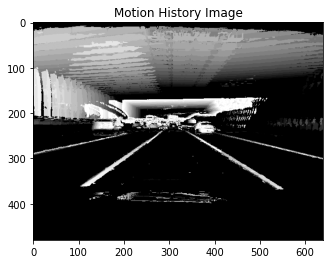

In [27]:
frames = get_frames('data/train.mp4', limit=20)
# Use some example hyperparameters
motion_images = motion_segmentation(frames, theta=10)
mhis = motion_history_images(motion_images, tau=20)

plt.imshow(normalize_and_scale(mhis[-1]), cmap='gray', vmin=0, vmax=255)
plt.title('Motion History Image')
plt.show()

## Training and Testing Sets

In [32]:
split = .95
# TODO: Use all frames
samples = 2000

# TODO: Tune MHI hyperparameters
theta = 10
tau = 20  # 20 frames = 1 second of movement?

def generate_data_set(filename):
    # Generates data set of MHI's for the given video file with shape: (num_images, channels=3, w, h)
    # MHI's are greyscale images but CNN models work with RGB images so we need to replicate the image across the 3 channels
    frames = get_frames(filename, limit=samples)
    motion_images = motion_segmentation(frames, theta=theta)
    mhis = np.asarray(motion_history_images(motion_images, tau=tau))
    # Replicate the image across 3 channels
    # See: https://stackoverflow.com/a/40119878
    mhis = np.stack((mhis, ) * 3, axis=-1)

    return mhis.reshape(-1, 3, mhis.shape[1], mhis.shape[2])

def load_train_speeds():
    # Loads the correct speeds for training with shape: (num_speeds, 1)
    with open('data/train.txt', 'r') as f:
        return np.expand_dims(np.array([float(l) for l in f.readlines()[:samples + 1]]), axis=-1)

# Generate the MHI's for the training video
train_X = generate_data_set('data/train.mp4')
train_y = load_train_speeds()

# Split into continuous training and dev sets
training_size = int(len(train_X) * split)
dev_X = train_X[training_size + 1:]
dev_y = train_y[training_size + 1:]
train_X = train_X[:training_size]
train_y = train_y[:training_size]

# Sanity check
assert len(train_X) == len(train_y), f'{len(train_X)} != {len(train_y)}'
assert len(dev_X) == len(dev_y), f'{len(dev_X)} != {len(dev_y)}'

# Generate the MHI's for the testing video
test_X = generate_motion_history_images('data/test.mp4')

print(f'Train set has {len(train_X)} frames')
print(f'Dev set has {len(dev_X)} frames')
print(f'Test set has {len(test_X)} frames')

Train set has 1900 frames
Dev set has 100 frames
Test set has 2001 frames


## Model Definition

In [40]:
# Choose device based on CPU vs GPU availability
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Use transfer learning
model = torchvision.models.resnet18(pretrained=True)

# Freeze all weights since we won't be tuning the full model
for param in model.parameters():
    param.requires_grad = False

# Replace the last layer with a linear (regression) output
features = model.fc.in_features
model.fc = nn.Linear(features, 1)

model = model.to(device)

# We'll use MSE as the loss
loss_fn = nn.MSELoss()

# Use Stochastic Gradient Descent, and optimize only the parameters of the last layer
# Add momentum to speed up training
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Also decay learning rate by a factor of 0.1 every 7 epochs
learning_rate_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## Model Training

In [41]:
# Convert training and dev set into Torch tensors to leverage `DataLoader`
# See: https://stackoverflow.com/a/44475689 and https://discuss.pytorch.org/t/converting-the-list-of-numpy-image-into-torch-tensor/8015/5
def to_tensor(array):
    # We need to convert to PyTorch's `float` explicitly since NumPy's `float64` is not allowed
    # See: https://discuss.pytorch.org/t/runtimeerror-expected-object-of-scalar-type-double-but-got-scalar-type-float-for-argument-2-weight/38961/14
    return array.float() if isinstance(array, torch.Tensor) else torch.from_numpy(array).float()

train_X = to_tensor(train_X)
train_y = to_tensor(train_y)
dev_X = to_tensor(dev_X)
dev_y = to_tensor(dev_y)

loaders = {x : DataLoader(TensorDataset(train_X, train_y), batch_size=64) for x in ['train', 'dev']}
sizes = {'train': train_X.shape[0], 'dev': dev_X.shape[0]}

In [ ]:
# Training routine modified from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#training-the-model
# TODO: Tune number of epochs
num_epochs = 5

start = time()

best_model = copy.deepcopy(model.state_dict())
best_loss = 0.0

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'dev']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0

        # Iterate over data
        for frames, speeds in loaders[phase]:
            frames = frames.to(device)
            speeds = speeds.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            # Track history if only in training
            with torch.set_grad_enabled(phase == 'train'):
                predictions = model(frames)
                loss = loss_fn(predictions, speeds)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * frames.size(0)

        # Decay learning rate when appropriate
        if phase == 'train':
            learning_rate_scheduler.step()

        # Global statistics
        epoch_loss = running_loss / sizes[phase]

        print('{} Loss: {:.4f}'.format(phase, epoch_loss))

        # Deep copy the best model based on the dev set
        if phase == 'dev' and epoch_loss > best_loss:
            best_loss = epoch_loss
            best_model = copy.deepcopy(model.state_dict())

    print()

time_elapsed = time() - start
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best dev loss: {:4f}'.format(nest_loss))

# Load best model weights
model.load_state_dict(best_model)